In [1]:
import os

import pandas as pd
import numpy as np

# store elements as dictionary keys and their counts as dictionary values
from collections import Counter

# scikit-learn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline

# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report

# Function for creating model pipelines - sklearn
from sklearn.pipeline import make_pipeline

# Function for creating model pipelines - imblearn
from imblearn.pipeline import make_pipeline as imbl_pipe

# Over-sampling using SMOTE
from imblearn.over_sampling import SMOTE


In [2]:
abt = pd.read_csv("../Resources/analytical_base_table.csv")
abt.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Models Training

## Let's start by splitting our dataframe into separate objects:

y for the target varibale

X for the input features

In [3]:
#Separate dataframe into separate object

# Object for target variable
y = abt.Exited

# object for input features
X = abt.drop(['Exited'], axis=1)

# display shapes of X and y
print(X.shape, y.shape)


(10000, 10) (10000,)


In [4]:
# List numerical features
num_columns = X.select_dtypes(include='number').columns.tolist()
num_columns

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [5]:
# List categorical features
cat_columns = X.select_dtypes(include='object').columns.tolist()
cat_columns

['Geography', 'Gender']

In [6]:
def class_count(a):
    counter=Counter(a)
    kv=[list(counter.keys()),list(counter.values())]
    abt2 = pd.DataFrame(np.array(kv).T, columns=['Exited','Count'])
    abt2['Count'] = abt2['Count'].astype('int64')
    abt2['%'] = round(abt2['Count'] / a.shape[0] * 100, 2)
    return abt2.sort_values('Count',ascending=False)

In [7]:
class_count(y)


,Exited,Count,%
1,0,7963,79.63
0,1,2037,20.37


## Create a Train Test Split

We will continue with splitting our data into separate training and test sets.

30% of observations will be set aside for the test set

the rest, 70%, will be used as the training set

In [8]:
random_state = 10

# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=random_state,
                                                    stratify=abt.Exited)

# Print number of observations in X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test), len(y_train), len(y_test))

7000 3000 7000 3000


In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7000 entries, 8061 to 4741
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      7000 non-null   int64  
 1   Geography        7000 non-null   object 
 2   Gender           7000 non-null   object 
 3   Age              7000 non-null   int64  
 4   Tenure           7000 non-null   int64  
 5   Balance          7000 non-null   float64
 6   NumOfProducts    7000 non-null   int64  
 7   HasCrCard        7000 non-null   int64  
 8   IsActiveMember   7000 non-null   int64  
 9   EstimatedSalary  7000 non-null   float64
dtypes: float64(2), int64(6), object(2)
memory usage: 601.6+ KB


## Pre-processing Pipeline
 
 ##Scale numerical data and encode categorical data
Construct a pre-processing pipeline from the given transformers: MinMaxScaler and OneHotEncoder Create lists of indexes from the list of column namesNeed to be numeric not string to specify columns name in column transformer

In [10]:
num_features = [] 

for i in num_columns:
    location = X.columns.get_loc(i)
    num_features.append(location)
print(num_features)  

[0, 3, 4, 5, 6, 7, 8, 9]


In [11]:
cat_features = []

for i in cat_columns:
    location = X.columns.get_loc(i)
    cat_features.append(location)
print(cat_features) 

[1, 2]


In [12]:
# Define column transformer
# Need to be numeric not string to specify columns name 
preprocess = make_column_transformer(
    (MinMaxScaler(), num_features),
    (OneHotEncoder(sparse=False), cat_features)
)
preprocess

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 [0, 3, 4, 5, 6, 7, 8, 9]),
                                ('onehotencoder', OneHotEncoder(sparse=False),
                                 [1, 2])])

In [13]:
# Import classifier
from sklearn.ensemble import RandomForestClassifier

# Define model with pipeline
model = imbl_pipe(preprocess,
                  SMOTE(sampling_strategy='auto', random_state=random_state),
                  RandomForestClassifier())

model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  [0, 3, 4, 5, 6, 7, 8, 9]),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  [1, 2])])),
                ('smote', SMOTE(random_state=10)),
                ('randomforestclassifier', RandomForestClassifier())])

In [14]:
 # Create the GridSearchCV model
# Create the GridSearch estimator along with a parameter object containing the values to adjust
from sklearn.model_selection import GridSearchCV
rf_param_grid = {
    'randomforestclassifier__n_estimators' : [50, 100, 150],
    'randomforestclassifier__max_features' : ['sqrt', 0.33],
    'randomforestclassifier__min_samples_leaf' : [1, 5 ,10, 15],
    'randomforestclassifier__criterion' : ['gini', 'entropy'],
    'randomforestclassifier__min_samples_split' : [2, 3, 4]
}
rf_grid = GridSearchCV(model, rf_param_grid, verbose=3, cv= 5, scoring='accuracy')

In [15]:
X_train = X_train.values
X_test = X_test.values

In [16]:
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5] END randomforestclassifier__criterion=gini, randomforestclassifier__max_features=sqrt, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=50;, score=0.841 total time=   0.6s
[CV 2/5] END randomforestclassifier__criterion=gini, randomforestclassifier__max_features=sqrt, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=50;, score=0.836 total time=   0.6s
[CV 3/5] END randomforestclassifier__criterion=gini, randomforestclassifier__max_features=sqrt, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=50;, score=0.834 total time=   0.6s
[CV 4/5] END randomforestclassifier__criterion=gini, randomforestclassifier__max_features=sqrt, randomforestclassifier__min_samples_leaf=1, randomforestclassifier_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         [0, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8,
                                                                          9]),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(sparse=False),
                                                                         [1,
                                                                          2])

In [17]:
print(rf_grid.best_params_)

{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 150}


In [18]:
print(rf_grid.best_score_)

0.8412857142857144


In [19]:
print(f"Training Data Score: {rf_grid.score(X_train, y_train)}")
print(f"Testing Data Score: {rf_grid.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8333333333333334


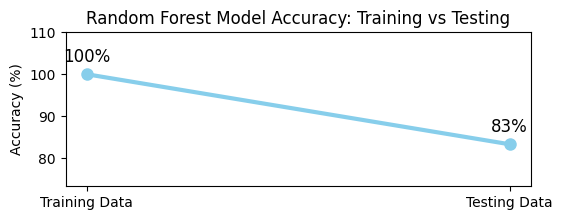

In [49]:
import matplotlib.pyplot as plt

# Data
scores = [rf_grid.score(X_train, y_train) * 100, rf_grid.score(X_test, y_test) * 100]
labels = ['Training Data', 'Testing Data']

# Create a figure with smaller size
plt.figure(figsize=(6, 2))  # Adjust the width and height as needed

# Plot with skyblue color for the line
plt.plot(labels, scores, marker='o', color='skyblue', linestyle='-', linewidth=3, markersize=8)

# Set the Y-axis limits to center the line
plt.ylim(min(scores) - 10, max(scores) + 10)  # Adjust this to make sure the line is centered within the plot

# Add labels and title
plt.ylabel('Accuracy (%)')
plt.title('Random Forest Model Accuracy: Training vs Testing')

# Adding the text on the plot
for i in range(len(scores)):
    plt.text(labels[i], scores[i] + 2, f'{int(scores[i])}%', ha='center', va='bottom', fontsize=12)

plt.show()


In [20]:
predictions = rf_grid.predict(X_test)
print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")

First 10 Predictions:   [0 0 0 0 1 1 0 0 0 0]
First 10 Actual labels: [1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


In [21]:
pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)

,Prediction,Actual
0,0,1
1,0,0
2,0,0
3,0,0
4,1,0
...,...,...
2995,0,0
2996,0,0
2997,0,0
2998,0,0


In [22]:
cm = confusion_matrix(y_test, predictions)
print(cm)

[[2122  267]
 [ 233  378]]


In [23]:
cm = np.around(cm / cm.sum(axis=1)[:, np.newaxis], 2)
print(cm)

[[0.89 0.11]
 [0.38 0.62]]


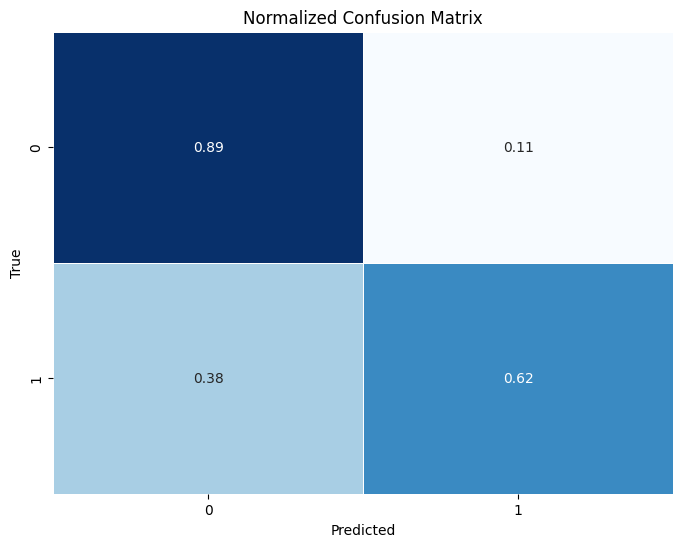

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    # Predict the labels
    y_pred = model.best_estimator_.predict(X_test)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Normalize the confusion matrix
    cm = np.around(cm / cm.sum(axis=1)[:, np.newaxis], 2)
    
    # Plot confusion matrix with color "kyblue"
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="0.2f", cmap='Blues', cbar=False, linewidths=0.5)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Call the function to plot the confusion matrix
plot_confusion_matrix(rf_grid, X_test, y_test)


In [24]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      2389
           1       0.59      0.62      0.60       611

    accuracy                           0.83      3000
   macro avg       0.74      0.75      0.75      3000
weighted avg       0.84      0.83      0.83      3000



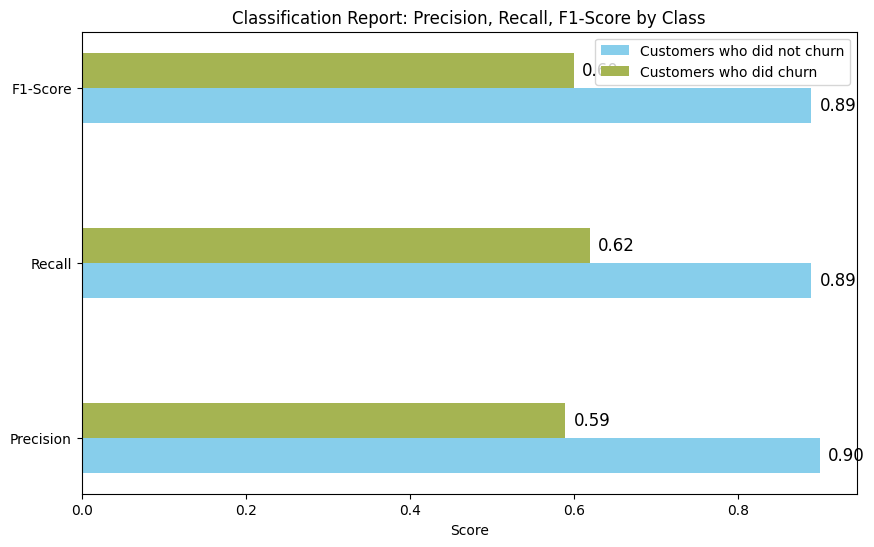

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Classification report metrics for customers who did not churn and did churn
metrics = ['Precision', 'Recall', 'F1-Score']
class_0_values = [0.90, 0.89, 0.89]  # For customers who did not churn
class_1_values = [0.59, 0.62, 0.60]  # For customers who did churn

# Bar colors
class_0_color = 'skyblue'  # Purple for class 0
class_1_color = '#A5B452'  # Olive for class 1

# Set the figure size
plt.figure(figsize=(10, 6))

# Create horizontal bars
bar_width = 0.2  # Reduced width of bars
index = np.arange(len(metrics))  # Position for each metric

# Plot bars for class 0 and class 1, side by side
bars_class_0 = plt.barh(index - bar_width / 2, class_0_values, bar_width, label='Customers who did not churn', color=class_0_color)
bars_class_1 = plt.barh(index + bar_width / 2, class_1_values, bar_width, label='Customers who did churn', color=class_1_color)

# Add labels and title
plt.xlabel('Score')
plt.title('Classification Report: Precision, Recall, F1-Score by Class')
plt.yticks(index, metrics)  # Set y-axis to show metrics
plt.legend()

# Adding text labels for the values on top of the bars
for i, bar in enumerate(bars_class_0):
    # Add value for class 0
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2, 
             f'{class_0_values[i]:.2f}', va='center', ha='left', fontsize=12, color='black')

for i, bar in enumerate(bars_class_1):
    # Add value for class 1
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2, 
             f'{class_1_values[i]:.2f}', va='center', ha='left', fontsize=12, color='black')

# Display the plot
plt.show()


In [25]:
pred = rf_grid.predict(X_test[:1])

In [26]:
print(f"Predicted classes: {pred}")
print(f"Actual Labels: {list(y_test[:1])}")

Predicted classes: [0]
Actual Labels: [1]


In [29]:
import joblib

filename = '../models/nate_random_forest.sav'
joblib.dump(rf_grid, filename)

['../models/nate_random_forest.sav']

In [30]:
rf_model = joblib.load(filename)
print(rf_model.score(X_test, y_test))

0.8333333333333334


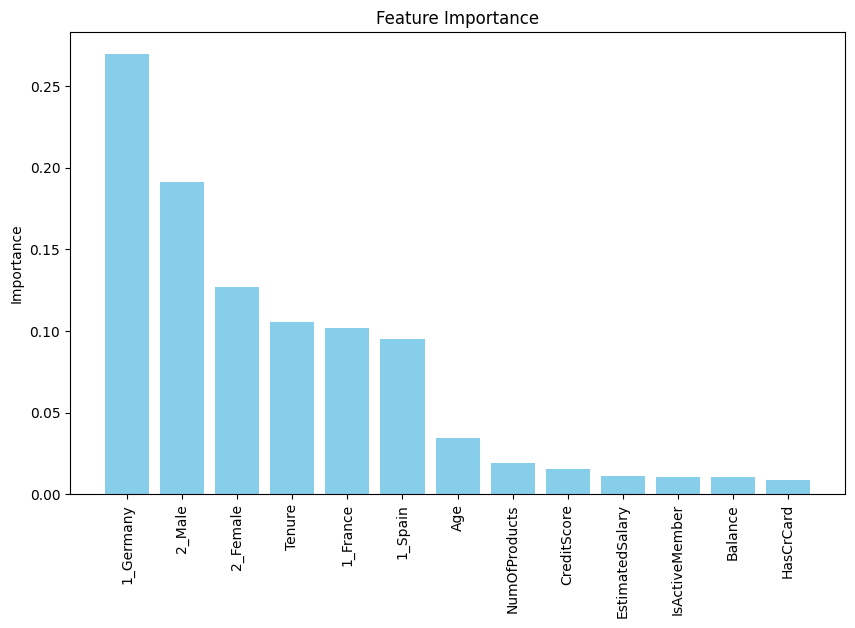

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_feature_importance(model, X, feature_names):
    # Get feature importance from the model
    importances = model.best_estimator_.named_steps['randomforestclassifier'].feature_importances_
    
    # Get the column transformer from the pipeline
    column_transformer = model.best_estimator_.named_steps['columntransformer']
    
    # Get the transformed feature names from the OneHotEncoder (for categorical columns)
    preprocessed_columns = []
    
    # Handle categorical columns using OneHotEncoder
    for transformer_name, transformer, columns in column_transformer.transformers_:  # Unpacking correctly
        if transformer_name == 'onehotencoder':
            # Ensure the column names passed to get_feature_names_out are strings
            columns = [str(col) for col in columns]
            # Get the feature names after one-hot encoding
            cat_columns = transformer.get_feature_names_out(columns)
            preprocessed_columns.extend(cat_columns)
    
    # Handle numerical columns directly from the input feature names
    for col in feature_names:
        if col in X.select_dtypes(include='number').columns:
            preprocessed_columns.append(col)
    
    # Create a DataFrame to associate features with their importance scores
    feature_importance = pd.DataFrame({
        'Feature': preprocessed_columns,
        'Importance': importances
    })
    
    # Sort the DataFrame by importance in descending order
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    
    # Plot the feature importance vertically
    plt.figure(figsize=(10, 6))
    plt.bar(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
    plt.ylabel('Importance')
    plt.title('Feature Importance')
    plt.xticks(rotation=90)  # Rotate the x-axis labels for better visibility
    plt.show()

# Call the function to plot feature importance
plot_feature_importance(rf_grid, X, num_columns)


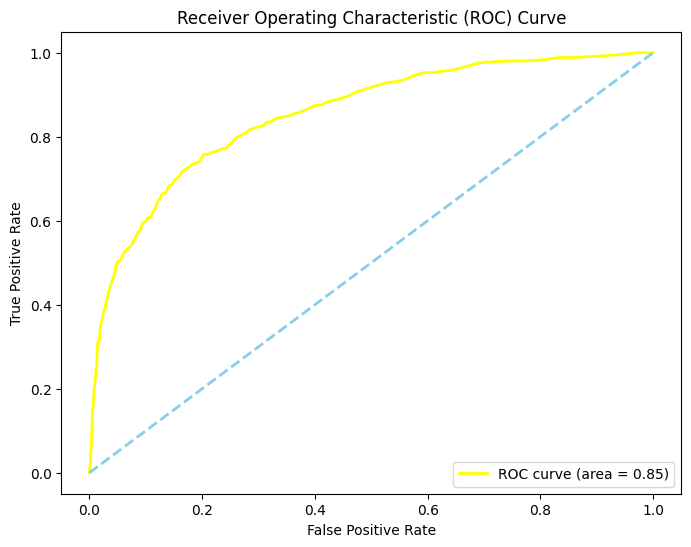

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, X_test, y_test):
    # Predict probabilities for the positive class (class 1)
    y_prob = model.best_estimator_.predict_proba(X_test)[:, 1]  # Get probabilities for class 1
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    # Calculate AUC (Area Under Curve)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='yellow', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='skyblue', lw=2, linestyle='--')  # Diagonal line (random classifier)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Call the function to plot the ROC curve
plot_roc_curve(rf_grid, X_test, y_test)


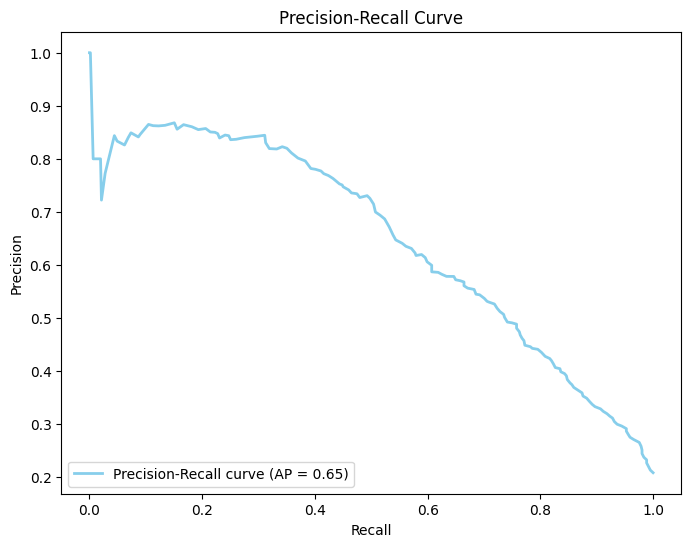

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curve(model, X_test, y_test):
    # Predict probabilities for the positive class (class 1)
    y_prob = model.best_estimator_.predict_proba(X_test)[:, 1]  # Get probabilities for class 1
    
    # Calculate Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    
    # Calculate Average Precision (AP)
    average_precision = average_precision_score(y_test, y_prob)
    
    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='skyblue', lw=2, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

# Call the function to plot the Precision-Recall curve
plot_precision_recall_curve(rf_grid, X_test, y_test)
